In [1]:
####### This part is about testing the final structure of the color identification, using siamese networks ##########
#######                               and histogram correlation                                            ##########

In [2]:
### Import libraries

import torch
import cv2
import time
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt


from bokeh.plotting import figure, show

from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# output_notebook()
import sys
sys.path.insert(1, r'C:\Users\TRMoussa-PCHP\OneDrive\PSC\psc\PSC')

from functions import *
import posenet
from Person import Person, Unknown_Person
from Color import Color

from util import draw_skeleton

VIDEO_PATH = r'C:\Users\TRMoussa-PCHP\OneDrive\PSC\videos'

output_video_path = r"C:\Users\TRMoussa-PCHP\OneDrive\PSC\psc\PSC\output"

weigths_path = r"C:\Users\TRMoussa-PCHP\OneDrive\PSC\psc\PSC\notebook\Deep_Model\weights"
output_histogram_path = r"C:\Users\TRMoussa-PCHP\OneDrive\PSC\psc\PSC\output_histogram"

In [3]:
### Constantes for trackers

PART_NAMES = [
    "nose", "leftEye", "rightEye", "leftEar", "rightEar", "leftShoulder",
    "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
    "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"
    ]

TARGETED_PART_IDS = [PART_NAMES.index(PART) for PART in ["rightShoulder", "leftHip",
                                                        "rightHip","leftShoulder"]]

Persons = []
num_pers = 2


In [4]:
## Load the posenet model

model = posenet.load_model(101)
model = model#.cuda()
output_stride = model.output_stride
scale_factor = 0.7125

## Function used to get all skeletons in one img, using posenet.
##
##  
def process_posenet(img, num_pose=2, min_pose_score=0.01, min_part_score=0.01):

    input_image, display_image, output_scale = posenet.utils._process_input(img, scale_factor=scale_factor, output_stride=output_stride)
    
    with torch.no_grad():
        input_image = torch.Tensor(input_image)#.cuda()

        heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result = model(input_image)

        pose_scores, keypoint_scores, keypoint_coords = posenet.decode_multiple_poses(
            heatmaps_result.squeeze(0),
            offsets_result.squeeze(0),
            displacement_fwd_result.squeeze(0),
            displacement_bwd_result.squeeze(0),
            output_stride=output_stride,
            max_pose_detections=num_pose,
            min_pose_score=min_pose_score)
    
    keypoint_coords *= output_scale

    keypoint_coords = np.array(keypoint_coords)
    keypoint_scores = np.array(keypoint_scores)
    pose_scores = np.array(pose_scores)
    display_img = np.array(display_image)
    
    return display_image, keypoint_coords, keypoint_scores, pose_scores

In [5]:
##############    First method evaluation Tracking using the histogram correlation method     ################


In [6]:
## Class for Tracking using Histogram correlation
class Tracker_Correl:
    num_pers = 2
    
    def __init__(self, videopath):
        self.num_pers = Tracker_Correl.num_pers
        self.cap = cv2.VideoCapture(videopath)
        self.frame = None
        
        self.person0 = Person('Person', '0')
        self.person1 = Person('Person', '1')
        
        self.persons = [self.person0, self.person1]

        
    def initialise(self):
        print('Begin initialisation')
        begin = time.time()
        detected_pers = 0
        while True:
            _, img =self.cap.read()
            img = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
            display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(img, num_pose=2, min_pose_score=0.01, min_part_score=0.01)
            
            keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                                TARGETED_PART_IDS, self.num_pers,
                                                min_pose_confidence=0.01, min_part_confidence=0.01)
            print(keypoint_list)
            
            for i, coords in enumerate(keypoint_list):
                
                
                if not contains_pers(display_image, self.persons, coords, crit=0.70) and i<self.num_pers:
                    self.persons[detected_pers].put_histogram(display_image, coords)
                    print("histogram putted for person_{}".format(detected_pers+1))
                    #print(type(perform_histogram(display_image, coords)))
                    detected_pers += 1
                    
            if(detected_pers == self.num_pers):
                break
            delta = int(time.time()-begin)  
            if(delta==120):
                raise Exeption('Initialisation failed')
        print('initialisation succed')
    
    def update(self):
        _,img = self.cap.read()
        self.frame = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
        display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(self.frame, num_pose=2, min_pose_score=0.1, min_part_score=0.10)
            
        keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                            TARGETED_PART_IDS, self.num_pers,
                                            min_pose_confidence=0.01, min_part_confidence=0.01)
            
        Dico_0, confidences_0 = self.person0.identifie_correl(self.frame, keypoint_list)
        Dico_1, confidences_1 = self.person1.identifie_correl(self.frame, keypoint_list)
        
        conf_0, conf_1 = link_confidences([confidences_0, confidences_1])
        
        self.person0.update(Dico_0[conf_0], conf_0)
        self.person1.update(Dico_1[conf_1], conf_1)
        
        print("Person_0 correl_Score : {}". format(self.person0.prob))
        print("Person_1 correl_Score : {} \n". format(self.person1.prob))
        
        return self.frame
        
    def draw(self):
        self.person0.draw(self.frame, 4)
        self.person1.draw(self.frame, 2)
        return self.frame

Begin initialisation
[]
[[array([123.22057105, 209.6332681 ]), array([171.07730988, 228.19505522])], [array([130.0887093 , 269.92120275]), array([176.70279231, 298.34396959])]]


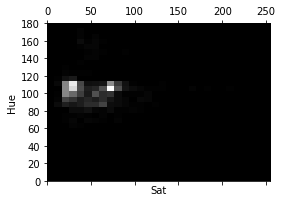

histogram putted for person_1
0.6215065805599571


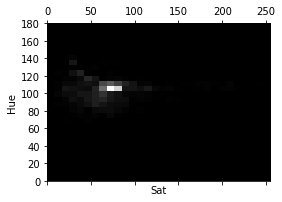

histogram putted for person_2
initialisation succed
Person_0 correl_Score : 0.9484566420494599
Person_1 correl_Score : 0.9793638254067849 

Person_0 correl_Score : 0.9911028101488952
Person_1 correl_Score : 0.876014051325741 

Person_0 correl_Score : 0.9587955975659
Person_1 correl_Score : 0.893106657191853 

Person_0 correl_Score : 0.949767890629128
Person_1 correl_Score : 0.9137183628049107 

Person_0 correl_Score : 0.9612351175328249
Person_1 correl_Score : 0.9726782370168607 

Person_0 correl_Score : 0.9827598648433404
Person_1 correl_Score : 0.9914826333184731 

Person_0 correl_Score : 0.9819034756579564
Person_1 correl_Score : 0.9350475895338027 

Person_0 correl_Score : 0.9760525481662178
Person_1 correl_Score : 0.9933745427952471 

Person_0 correl_Score : 0.9754397416907229
Person_1 correl_Score : 0.9853025479727358 

Person_0 correl_Score : 0.9762892270128269
Person_1 correl_Score : 0.9941511672217715 

Person_0 correl_Score : 0.990968278253317
Person_1 correl_Score : 0.995458

Person_0 correl_Score : 0.8309373126115804
Person_1 correl_Score : 0.4664022184268463 

Person_0 correl_Score : 0.8386485203687953
Person_1 correl_Score : 0.38099003231323425 

Person_0 correl_Score : 0.8386595989382368
Person_1 correl_Score : 0.6073344155630319 

Person_0 correl_Score : 0.8107817629651826
Person_1 correl_Score : 0.4477706771214512 

Person_0 correl_Score : 0.818805523280479
Person_1 correl_Score : 0.44560895947737533 

Person_0 correl_Score : 0.803954058022478
Person_1 correl_Score : 0.4221517460489315 

Person_0 correl_Score : 0.7695584966780856
Person_1 correl_Score : 0.3801567179912574 

Person_0 correl_Score : 0.8276703537234712
Person_1 correl_Score : 0.39585994986096573 

Person_0 correl_Score : 0.8344936146338406
Person_1 correl_Score : 0.4203615509950975 

Person_0 correl_Score : 0.8439654257190932
Person_1 correl_Score : 0.45112361606608603 

Person_0 correl_Score : 0.863499057014064
Person_1 correl_Score : 0.4573872647297305 

Person_0 correl_Score : 0.85260

Person_0 correl_Score : 0.4255727084246186
Person_1 correl_Score : 0.7864649205428935 

Person_0 correl_Score : 0.7266295096703214
Person_1 correl_Score : 0.7555424493678502 

Person_0 correl_Score : 0.4125740710539086
Person_1 correl_Score : 0.7633930952582789 

Person_0 correl_Score : 0.4633101529602462
Person_1 correl_Score : 0.6945338113533488 

Person_0 correl_Score : 0.45767080442087577
Person_1 correl_Score : 0.8160707318942568 

Person_0 correl_Score : 0.2940620233641672
Person_1 correl_Score : 0.7507740442419082 

Person_0 correl_Score : 0.33197410923309595
Person_1 correl_Score : 0.7465544086561046 

Person_0 correl_Score : 0.46989427329056627
Person_1 correl_Score : 0.8048795328461928 

Person_0 correl_Score : 0.5048088653152426
Person_1 correl_Score : 0.7755780314178975 

Person_0 correl_Score : 0.6279901961499345
Person_1 correl_Score : 0.7589490882164812 

Person_0 correl_Score : 0.5196290993779129
Person_1 correl_Score : 0.8232865508888157 

Person_0 correl_Score : 0.467

Person_0 correl_Score : 0.4164291761494815
Person_1 correl_Score : 0.81740424828693 

Person_0 correl_Score : 0.597182242723363
Person_1 correl_Score : 0.8481839498768593 

Person_0 correl_Score : 0.529434925183789
Person_1 correl_Score : 0.8480316101925163 

Person_0 correl_Score : 0.6339266661428351
Person_1 correl_Score : 0.8329959602307061 

Person_0 correl_Score : 0.6087068630933835
Person_1 correl_Score : 0.7830751701025682 

Person_0 correl_Score : 0.551195876469262
Person_1 correl_Score : 0.7653094514197681 

Person_0 correl_Score : 0.38875513887380686
Person_1 correl_Score : 0.800033360000419 

Person_0 correl_Score : 0.6140257925881876
Person_1 correl_Score : 0.810933618337966 

Person_0 correl_Score : 0.5637591675649389
Person_1 correl_Score : 0.7588203299066415 

Person_0 correl_Score : 0.7532722290710099
Person_1 correl_Score : 0.7409861796526561 

Person_0 correl_Score : 0.7733554336750386
Person_1 correl_Score : 0.7355610008762492 

Person_0 correl_Score : 0.322708610669

In [7]:
#####      Test of the method       ######
##########################################

#### path of the video
path = VIDEO_PATH+r'\Duo_2.wmv'
videoWriter = cv2.VideoWriter(os.path.join(output_video_path,"test_correl_300.mp4"),cv2.VideoWriter_fourcc('I','4','2','0'),10,(512,288))

tracker = Tracker_Correl(path)

##### Initialisation of the tracker
tracker.initialise()

#### Tracking phase
frame_count = 0
while True:
    img = tracker.update()
    img = tracker.draw()
    videoWriter.write(img)
    cv2.imshow('Track', img)
    frame_count += 1
    if( cv2.waitKey(1) == ord('q') or frame_count == 300):
        videoWriter.release()
        cv2.destroyAllWindows()
        break


In [7]:
# Load histograms for time evaluation

hist_1 = cv2.imread(os.path.join(output_histogram_path, "hist_Person_0_1.png"), 0).astype(np.float32) / 255
hist_2 = cv2.imread(os.path.join(output_histogram_path, "hist_Person_0_18.png"), 0).astype(np.float32) / 255

%timeit distance = dist = cv2.compareHist(hist_1, hist_2, cv2.HISTCMP_CORREL)

7.64 µs ± 3.91 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
##############    Second method evaluation Tracking using the Siamese network method     ################


In [8]:
#### Fonctions used during training of the network for initialising weights and bias

def initialize_weights(shape, name = None, dtype = None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name = None, dtype = None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [9]:
### load the trained siamese network model for visualising

with CustomObjectScope({'initialize_weights':initialize_weights,'initialize_bias':initialize_bias}):
    loadded_model = load_model(os.path.join(weigths_path, 'model_siamese_first.h5'))

In [10]:
loadded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 30, 30, 1)]  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 30, 30, 1)]  0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 4096)         1382528     input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4096)         0           sequential_5[1][0]         

In [11]:
### Class for tracking using Siamese Network
class Tracker_Siamese:
    
    num_pers = 2
    
    def __init__(self, videopath):
        self.num_pers = Tracker_Siamese.num_pers
        self.cap = cv2.VideoCapture(videopath)
        self.frame = None
        
        self.person0 = Person('Person', '0')
        self.person1 = Person('Person', '1')
        
        self.persons = [self.person0, self.person1]
        
        self.model = None

    def load_model(self):
        
        ## Load the model as above
        with CustomObjectScope({'initialize_weights':initialize_weights,'initialize_bias':initialize_bias}):
            loadded_model = load_model(os.path.join(weigths_path, 'model_siamese_first.h5'))
        
        self.model = loadded_model
        
        for i in range(len(self.persons)):
            self.persons[i].load_model(loadded_model)
    
    def initialise(self):
        print('Begin initialisation')
        begin = time.time()
        detected_pers = 0
        while True:
            _, img =self.cap.read()
            img = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
            display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(img, num_pose=2, min_pose_score=0.01, min_part_score=0.01)
            
            keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                                TARGETED_PART_IDS, self.num_pers,
                                                min_pose_confidence=0.01, min_part_confidence=0.01)
            print(keypoint_list)
            
            for i, coords in enumerate(keypoint_list):
                
                
                if not contains_pers(display_image, self.persons, coords, crit=0.70) and i<self.num_pers:
                    self.persons[detected_pers].put_histogram(display_image, coords)
                    #print(type(perform_histogram(display_image, coords)))
                    detected_pers += 1
                    
            if(detected_pers == self.num_pers):
                break
            delta = int(time.time()-begin)  
            if(delta==120):
                raise Exeption('Initialisation failed')
        print('initialisation succed')
    
    
    def update(self):
        _,img = self.cap.read()
        self.frame = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
        display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(self.frame, num_pose=2, min_pose_score=0.1, min_part_score=0.10)
            
        keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                            TARGETED_PART_IDS, self.num_pers,
                                            min_pose_confidence=0.01, min_part_confidence=0.01)
        
        Dico_0, confidences_0 = self.person0.identifie_model(self.frame, keypoint_list)
        Dico_1, confidences_1 = self.person1.identifie_model(self.frame, keypoint_list)

        conf_0, conf_1 = link_confidences([confidences_0, confidences_1])
        
        self.person0.update(Dico_0[conf_0], conf_0)
        self.person1.update(Dico_1[conf_1], conf_1)
        
        print("One_Shot score Person_0 : {} ".format(self.person0.prob))
        print("One_Shot score Person_1 : {} \n".format(self.person1.prob))
        
        return self.frame
    
        
    def draw(self):
        img = self.person0.draw(self.frame, 4)
        img = self.person1.draw(self.frame, 2)
        #cv2.imshow('Track', img)
        return img
    
    

Model loadded
Model loadded
Begin initialisation
[]
[[array([123.22057105, 209.6332681 ]), array([171.07730988, 228.19505522])], [array([130.0887093 , 269.92120275]), array([176.70279231, 298.34396959])]]


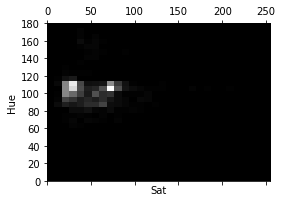

0.6215065805599571


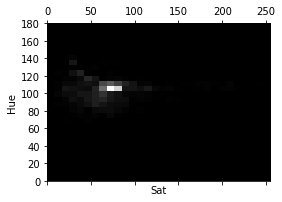

initialisation succed
One_Shot score Person_0 : 0.3707088828086853 
One_Shot score Person_1 : 0.2241838574409485 

One_Shot score Person_0 : 0.21342253684997559 
One_Shot score Person_1 : 0.19060450792312622 

One_Shot score Person_0 : 0.22847050428390503 
One_Shot score Person_1 : 0.31680721044540405 

One_Shot score Person_0 : 0.21722441911697388 
One_Shot score Person_1 : 0.3274420499801636 

One_Shot score Person_0 : 0.23531454801559448 
One_Shot score Person_1 : 0.24229657649993896 

One_Shot score Person_0 : 0.21561139822006226 
One_Shot score Person_1 : 0.2656005024909973 

One_Shot score Person_0 : 0.34352612495422363 
One_Shot score Person_1 : 0.3025668263435364 

One_Shot score Person_0 : 0.34849780797958374 
One_Shot score Person_1 : 0.2953096628189087 

One_Shot score Person_0 : 0.3725348114967346 
One_Shot score Person_1 : 0.18110054731369019 

One_Shot score Person_0 : 0.36875200271606445 
One_Shot score Person_1 : 0.16190117597579956 

One_Shot score Person_0 : 0.3503583

One_Shot score Person_0 : 0.28847193717956543 
One_Shot score Person_1 : 0.2934739589691162 

One_Shot score Person_0 : 0.29347938299179077 
One_Shot score Person_1 : 0.3025721311569214 

One_Shot score Person_0 : 0.32872503995895386 
One_Shot score Person_1 : 0.32026177644729614 

One_Shot score Person_0 : 0.29122573137283325 
One_Shot score Person_1 : 0.3645440936088562 

One_Shot score Person_0 : 0.18781542778015137 
One_Shot score Person_1 : 0.34752535820007324 

One_Shot score Person_0 : 0.09992474317550659 
One_Shot score Person_1 : 0.2896271347999573 

One_Shot score Person_0 : 0.11489623785018921 
One_Shot score Person_1 : 0.3126593232154846 

One_Shot score Person_0 : 0.1973438262939453 
One_Shot score Person_1 : 0.3227840065956116 

One_Shot score Person_0 : 0.271848201751709 
One_Shot score Person_1 : 0.3238673806190491 

One_Shot score Person_0 : 0.2612497806549072 
One_Shot score Person_1 : 0.2547093629837036 

One_Shot score Person_0 : 0.3168267607688904 
One_Shot score P

One_Shot score Person_0 : 0.06449562311172485 
One_Shot score Person_1 : 0.06723082065582275 

One_Shot score Person_0 : 0.1817367672920227 
One_Shot score Person_1 : 0.1567925214767456 

One_Shot score Person_0 : 0.3875870108604431 
One_Shot score Person_1 : 0.2731151580810547 

One_Shot score Person_0 : 0.24165332317352295 
One_Shot score Person_1 : 0.15844595432281494 

One_Shot score Person_0 : 0.371743381023407 
One_Shot score Person_1 : 0.2585664391517639 

One_Shot score Person_0 : 0.2863723635673523 
One_Shot score Person_1 : 0.20355892181396484 

One_Shot score Person_0 : 0.13173729181289673 
One_Shot score Person_1 : 0.2074880599975586 

One_Shot score Person_0 : 0.09081834554672241 
One_Shot score Person_1 : 0.16718757152557373 

One_Shot score Person_0 : 0.09617650508880615 
One_Shot score Person_1 : 0.18382954597473145 

One_Shot score Person_0 : 0.13818764686584473 
One_Shot score Person_1 : 0.21646076440811157 

One_Shot score Person_0 : 0.14914226531982422 
One_Shot sco

One_Shot score Person_0 : 0.02187138795852661 
One_Shot score Person_1 : 0.1591724157333374 

One_Shot score Person_0 : 0.1952037811279297 
One_Shot score Person_1 : 0.04025447368621826 

One_Shot score Person_0 : 0.020013511180877686 
One_Shot score Person_1 : 0.13905596733093262 

One_Shot score Person_0 : 0.0215795636177063 
One_Shot score Person_1 : 0.15452826023101807 

One_Shot score Person_0 : 0.029629111289978027 
One_Shot score Person_1 : 0.1546204686164856 

One_Shot score Person_0 : 0.049508094787597656 
One_Shot score Person_1 : 0.19399875402450562 

One_Shot score Person_0 : 0.1621403694152832 
One_Shot score Person_1 : 0.17665398120880127 

One_Shot score Person_0 : 0.09729182720184326 
One_Shot score Person_1 : 0.24164152145385742 

One_Shot score Person_0 : 0.08847677707672119 
One_Shot score Person_1 : 0.3461782932281494 

One_Shot score Person_0 : 0.1857924461364746 
One_Shot score Person_1 : 0.18540072441101074 

One_Shot score Person_0 : 0.19273513555526733 
One_Sho

In [14]:
##### Test of the method ######
###############################

#### path of the video
path = VIDEO_PATH+r'\Duo_2.wmv'
videoWriter = cv2.VideoWriter(os.path.join(output_video_path,"test_siamese_first_300.mp4"),cv2.VideoWriter_fourcc('I','4','2','0'),10,(512,288))
#cv2.namedWindow('Track')

tracker = Tracker_Siamese(path)

##### Initialisation of the tracker
tracker.load_model()
tracker.initialise()

#### Tracking phase
frame_count = 0
while True:
    img = tracker.update()
    img = tracker.draw()
    videoWriter.write(img)
    cv2.imshow('Track', img)
    frame_count += 1
    if(cv2.waitKey(1) == ord('q') or frame_count == 300):
        videoWriter.release()
        cv2.destroyAllWindows()
        break


In [13]:
# Load histograms for time evaluation

hist_1 = cv2.imread(os.path.join(output_histogram_path, "hist_Person_0_1.png"), 0).astype(np.float32) / 255
hist_2 = cv2.imread(os.path.join(output_histogram_path, "hist_Person_0_18.png"), 0).astype(np.float32) / 255

%timeit prediction = tracker.model.predict([hist_1.reshape(1,30,30,1), hist_2.reshape(1,30,30,1)])

NameError: name 'tracker' is not defined

In [12]:
### Same method with a different Siamese network model

In [13]:
#### Fonctions used during training of the network for initialising weights and bias

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [14]:
from tensorflow.keras.utils import CustomObjectScope
#help(tf.keras.initialisations)
with CustomObjectScope({'initialize_weights':initialize_weights,'initialize_bias':initialize_bias,
                       'contrastive_loss': contrastive_loss}):
    loadded_model = load_model(os.path.join(weigths_path, 'model_siamese_second.h5'))

In [15]:
loadded_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 30, 30, 1)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 30, 30, 1)]  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 128)          148352      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_2[1][0]              

In [16]:


### Class for tracking using Siamese Network
class Tracker_Siamese_Second:
    
    num_pers = 2
    
    def __init__(self, videopath):
        self.num_pers = Tracker_Siamese_Second.num_pers
        self.cap = cv2.VideoCapture(videopath)
        self.frame = None
        
        self.person0 = Person('Person', '0')
        self.person1 = Person('Person', '1')
        
        self.persons = [self.person0, self.person1]
        
        self.model = None

    def load_model(self):
        
        ## Load the model as above
        with CustomObjectScope({'initialize_weights':initialize_weights,'initialize_bias':initialize_bias,
                       'contrastive_loss': contrastive_loss}):
            loadded_model = load_model(os.path.join(weigths_path, 'model_siamese_second.h5'))
        
        self.model = loadded_model
        
        for i in range(len(self.persons)):
            self.persons[i].load_model(loadded_model)
    
    def initialise(self):
        print('Begin initialisation')
        begin = time.time()
        detected_pers = 0
        while True:
            _, img =self.cap.read()
            img = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
            display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(img, num_pose=2, min_pose_score=0.01, min_part_score=0.01)
            
            keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                                TARGETED_PART_IDS, self.num_pers,
                                                min_pose_confidence=0.01, min_part_confidence=0.01)
            print(keypoint_list)
            
            for i, coords in enumerate(keypoint_list):
                
                
                if not contains_pers(display_image, self.persons, coords, crit=0.70) and i<self.num_pers:
                    self.persons[detected_pers].put_histogram(display_image, coords)
                    #print(type(perform_histogram(display_image, coords)))
                    detected_pers += 1
                    
            if(detected_pers == self.num_pers):
                break
            delta = int(time.time()-begin)  
            if(delta==120):
                raise Exeption('Initialisation failed')
        print('initialisation succed')
    
    
    def update(self):
        _,img = self.cap.read()
        self.frame = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
        display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(self.frame, num_pose=2, min_pose_score=0.1, min_part_score=0.10)
            
        keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                            TARGETED_PART_IDS, self.num_pers,
                                            min_pose_confidence=0.01, min_part_confidence=0.01)
        
        Dico_0, confidences_0 = self.person0.identifie_model(self.frame, keypoint_list)
        Dico_1, confidences_1 = self.person1.identifie_model(self.frame, keypoint_list)

        conf_0, conf_1 = link_confidences([confidences_0, confidences_1])
        
        self.person0.update(Dico_0[conf_0], conf_0)
        self.person1.update(Dico_1[conf_1], conf_1)
        
        print("One_Shot score Person_0 : {} ".format(self.person0.prob))
        print("One_Shot score Person_1 : {} \n".format(self.person1.prob))
        
        return self.frame
    
        
    def draw(self):
        img = self.person0.draw(self.frame, 4)
        img = self.person1.draw(self.frame, 2)
        #cv2.imshow('Track', img)
        return img
    
    

Model loadded
Model loadded
Begin initialisation
[]
[[array([123.22057105, 209.6332681 ]), array([171.07730988, 228.19505522])], [array([130.0887093 , 269.92120275]), array([176.70279231, 298.34396959])]]


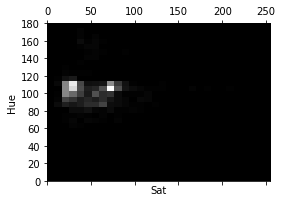

0.6215065805599571


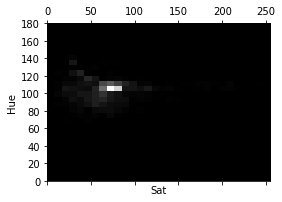

initialisation succed
One_Shot score Person_0 : 0.7495158910751343 
One_Shot score Person_1 : 0.9683666080236435 

One_Shot score Person_0 : 0.6329721510410309 
One_Shot score Person_1 : 0.8037653565406799 

One_Shot score Person_0 : 0.8343900740146637 
One_Shot score Person_1 : 0.7894495725631714 

One_Shot score Person_0 : 0.8349492996931076 
One_Shot score Person_1 : 0.7866817116737366 

One_Shot score Person_0 : 0.7931532710790634 
One_Shot score Person_1 : 0.8425491750240326 

One_Shot score Person_0 : 0.8346261084079742 
One_Shot score Person_1 : 0.8804664611816406 

One_Shot score Person_0 : 0.8094110637903214 
One_Shot score Person_1 : 0.9776443243026733 

One_Shot score Person_0 : 0.8213649392127991 
One_Shot score Person_1 : 0.9383768662810326 

One_Shot score Person_0 : 0.789003387093544 
One_Shot score Person_1 : 0.8900371864438057 

One_Shot score Person_0 : 0.8040235191583633 
One_Shot score Person_1 : 0.8782865405082703 

One_Shot score Person_0 : 0.8127637207508087 
One

One_Shot score Person_0 : 0.7524654418230057 
One_Shot score Person_1 : 0.4907032251358032 

One_Shot score Person_0 : 0.7789517790079117 
One_Shot score Person_1 : 0.7537830322980881 

One_Shot score Person_0 : 0.7378361821174622 
One_Shot score Person_1 : 0.5710577666759491 

One_Shot score Person_0 : 0.7197096943855286 
One_Shot score Person_1 : 0.3404049277305603 

One_Shot score Person_0 : 0.7264567911624908 
One_Shot score Person_1 : -0.023049473762512207 

One_Shot score Person_0 : 0.6989721953868866 
One_Shot score Person_1 : -0.3105137348175049 

One_Shot score Person_0 : 0.7155420482158661 
One_Shot score Person_1 : -0.3232293128967285 

One_Shot score Person_0 : 0.7377081513404846 
One_Shot score Person_1 : -0.005284786224365234 

One_Shot score Person_0 : 0.8036929219961166 
One_Shot score Person_1 : -0.014011025428771973 

One_Shot score Person_0 : 0.7849447876214981 
One_Shot score Person_1 : 0.008784353733062744 

One_Shot score Person_0 : 0.8286882191896439 
One_Shot sc

One_Shot score Person_0 : -0.12708330154418945 
One_Shot score Person_1 : 0.23868757486343384 

One_Shot score Person_0 : -0.11011207103729248 
One_Shot score Person_1 : 0.23818856477737427 

One_Shot score Person_0 : 0.0013561844825744629 
One_Shot score Person_1 : 0.6210262179374695 

One_Shot score Person_0 : -0.03290438652038574 
One_Shot score Person_1 : 0.4519655108451843 

One_Shot score Person_0 : -0.05407154560089111 
One_Shot score Person_1 : 0.5641466677188873 

One_Shot score Person_0 : 0.46802282333374023 
One_Shot score Person_1 : 0.6016902923583984 

One_Shot score Person_0 : 0.3009568452835083 
One_Shot score Person_1 : 0.9968695640563965 

One_Shot score Person_0 : 0.20690417289733887 
One_Shot score Person_1 : 0.9688111618161201 

One_Shot score Person_0 : 0.4098966717720032 
One_Shot score Person_1 : 0.9857059549540281 

One_Shot score Person_0 : 0.4396880865097046 
One_Shot score Person_1 : 0.8810481876134872 

One_Shot score Person_0 : 0.4882698655128479 
One_Shot 

One_Shot score Person_0 : -0.09126174449920654 
One_Shot score Person_1 : 0.6499930024147034 

One_Shot score Person_0 : -0.07614922523498535 
One_Shot score Person_1 : 0.5317595303058624 

One_Shot score Person_0 : 0.3547576665878296 
One_Shot score Person_1 : -0.494290828704834 

One_Shot score Person_0 : -0.09688293933868408 
One_Shot score Person_1 : 0.6217161417007446 

One_Shot score Person_0 : -0.07964944839477539 
One_Shot score Person_1 : 0.5314427018165588 

One_Shot score Person_0 : -0.08365476131439209 
One_Shot score Person_1 : 0.8810242414474487 

One_Shot score Person_0 : 0.02065908908843994 
One_Shot score Person_1 : 0.9980609853519127 

One_Shot score Person_0 : 0.3605195879936218 
One_Shot score Person_1 : 0.8159319758415222 

One_Shot score Person_0 : 0.4242483973503113 
One_Shot score Person_1 : 0.9103283435106277 

One_Shot score Person_0 : 0.014581501483917236 
One_Shot score Person_1 : 0.6955010294914246 

One_Shot score Person_0 : -0.08476018905639648 
One_Shot 

In [21]:
##### Test of the method ######
###############################

#### path of the video
path = VIDEO_PATH+r'\Duo_2.wmv'
videoWriter = cv2.VideoWriter(os.path.join(output_video_path,"test_siamese_second_300.mp4"),cv2.VideoWriter_fourcc('I','4','2','0'),10,(512,288))
#cv2.namedWindow('Track')

tracker = Tracker_Siamese_Second(path)

##### Initialisation of the tracker
tracker.load_model()
tracker.initialise()

#### Tracking phase
frame_count = 0
while True:
    img = tracker.update()
    img = tracker.draw()
    videoWriter.write(img)
    cv2.imshow('Track', img)
    frame_count += 1
    if(cv2.waitKey(1) == ord('q') or frame_count == 300):
        videoWriter.release()
        cv2.destroyAllWindows()
        break


In [22]:
# Load histograms for time evaluation

hist_1 = cv2.imread(os.path.join(output_histogram_path, "hist_Person_0_1.png"), 0).astype(np.float32) / 255
hist_2 = cv2.imread(os.path.join(output_histogram_path, "hist_Person_0_18.png"), 0).astype(np.float32) / 255

%timeit prediction = tracker.model.predict([hist_1.reshape(1,30,30,1), hist_2.reshape(1,30,30,1)])

3.6 ms ± 446 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
##############    Third method evaluation Tracking using the Siamese network method     ################
##############    This is the final method that will be use in our project              ################


In [18]:
## Hyper Parameter
lambda_factor = 0.8

In [19]:
### Class for tracking using Siamese Network
class Tracker_Final:
    
    num_pers = 2
    
    def __init__(self, videopath):
        self.num_pers = Tracker_Final.num_pers
        self.cap = cv2.VideoCapture(videopath)
        self.frame = None
        
        self.person0 = Person('Person', '0')
        self.person1 = Person('Person', '1')
        
        self.persons = [self.person0, self.person1]
        
        self.model = None

    def load_model(self):
        
        ## Load the model as above
        with CustomObjectScope({'initialize_weights':initialize_weights,'initialize_bias':initialize_bias,
                       'contrastive_loss': contrastive_loss}):
            loadded_model = load_model(os.path.join(weigths_path, 'model_siamese_second.h5'))
            
        self.model = loadded_model
        
        for i in range(len(self.persons)):
            self.persons[i].load_model(loadded_model)
    
    def initialise(self):
        print('Begin initialisation')
        begin = time.time()
        detected_pers = 0
        while True:
            _, img =self.cap.read()
            img = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
            display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(img, num_pose=2, min_pose_score=0.01, min_part_score=0.01)
            
            keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                                TARGETED_PART_IDS, self.num_pers,
                                                min_pose_confidence=0.01, min_part_confidence=0.01)
            print(keypoint_list)
            
            for i, coords in enumerate(keypoint_list):
                
                
                if not contains_pers(display_image, self.persons, coords, crit=0.70) and i<self.num_pers:
                    self.persons[detected_pers].put_histogram(display_image, coords)
                    #print(type(perform_histogram(display_image, coords)))
                    detected_pers += 1
                    
            if(detected_pers == self.num_pers):
                break
            delta = int(time.time()-begin)  
            if(delta==120):
                raise Exeption('Initialisation failed')
        print('initialisation succed')
    
    
    def update(self):
        _,img = self.cap.read()
        self.frame = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
        display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(self.frame, num_pose=2, min_pose_score=0.1, min_part_score=0.10)
            
        keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                            TARGETED_PART_IDS, self.num_pers,
                                            min_pose_confidence=0.01, min_part_confidence=0.01)
        
        Dico_0, confidences_0 = self.person0.identifie_cross_2(self.frame, keypoint_list, lambda_factor)
        Dico_1, confidences_1 = self.person1.identifie_cross_2(self.frame, keypoint_list, lambda_factor)
        
        conf_0, conf_1 = link_confidences([confidences_0, confidences_1])
        
        self.person0.update(Dico_0[conf_0], conf_0)
        self.person1.update(Dico_1[conf_1], conf_1)
        
        #print(a==None,b==None)
        print("Mixed_Score for person_0 : {}".format(self.person0.prob))
        print("Mixed_Score for person_1 : {}".format(self.person1.prob))
        
        return self.frame
    
    def draw(self):
        img = self.person0.draw(self.frame, 5)
        img = self.person1.draw(self.frame, 2)
        #cv2.imshow('Track', img)
        return img
    
    

In [20]:
### Class for tracking using Siamese Network
class Tracker_Final:
    
    num_pers = 2
    
    def __init__(self, videopath):
        self.num_pers = Tracker_Final.num_pers
        self.cap = cv2.VideoCapture(videopath)
        self.frame = None
        
        self.person0 = Person('Person', '0')
        self.person1 = Person('Person', '1')
        
        self.persons = [self.person0, self.person1]
        
        self.model = None
        
        self.conf_list = None

    def load_model(self):
        
        ## Load the model as above
        with CustomObjectScope({'initialize_weights':initialize_weights,'initialize_bias':initialize_bias,
                       'contrastive_loss': contrastive_loss}):
            loadded_model = load_model(os.path.join(weigths_path, 'model_siamese_second.h5'))
            
        self.model = loadded_model
        
        for i in range(len(self.persons)):
            self.persons[i].load_model(loadded_model)
    
    def initialise(self):
        print('Begin initialisation')
        begin = time.time()
        detected_pers = 0
        while True:
            _, img =self.cap.read()
            img = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
            display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(img, num_pose=2, min_pose_score=0.01, min_part_score=0.01)
            
            keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                                TARGETED_PART_IDS, self.num_pers,
                                                min_pose_confidence=0.01, min_part_confidence=0.01)
            print(keypoint_list)
            
            for i, coords in enumerate(keypoint_list):
                
                
                if not contains_pers(display_image, self.persons, coords, crit=0.70) and i<self.num_pers:
                    self.persons[detected_pers].put_histogram(display_image, coords)
                    #print(type(perform_histogram(display_image, coords)))
                    detected_pers += 1
                    
            if(detected_pers == self.num_pers):
                break
            delta = int(time.time()-begin)  
            if(delta==120):
                raise Exeption('Initialisation failed')
        print('initialisation succed')
    
    
    def update(self):
        _,img = self.cap.read()
        self.frame = img #cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
        display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(self.frame, num_pose=2, min_pose_score=0.1, min_part_score=0.10)
            
        #keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
        #                                    TARGETED_PART_IDS, self.num_pers,
        #                                    min_pose_confidence=0.01, min_part_confidence=0.01)
        self.conf_list = keypoint_scores
        
        #Dico_0, confidences_0 = self.person0.identifie_cross(self.frame, keypoint_list, keypoint_coords, lambda_factor)
        #Dico_1, confidences_1 = self.person1.identifie_cross(self.frame, keypoint_list, keypoint_coords, lambda_factor)
        
        #if(len(confidences_0) == len(confidences_1) and len(confidences_0)>0):
        #    conf_0, conf_1 = link_confidences_2(confidences_0, confidences_1)
        
        #    self.person0.update(Dico_0[conf_0], conf_0)
        #    self.person1.update(Dico_1[conf_1], conf_1)
        
        #print(a==None,b==None)
        #print("Mixed_Score for person_0 : {}".format(self.person0.prob))
        #print("Mixed_Score for person_1 : {}".format(self.person1.prob))
        
        ################
        # COLOR if color can be use
        non_match_list = self.persons
        cs_tup_list = [(keypoint_coords[i],keypoint_scores[i]) for i in range(len(pose_scores)) if pose_scores[i]>0.05]
        
        num_person = len(non_match_list)
        num_tup_list = len(cs_tup_list)

        # if we have more oerson than given squeletons, we attribute a None element to these we don't have and 0 score
        if(num_tup_list<num_person):
            for i in range(num_person - num_tup_list):
                cs_tup_list.append((None, None))
            
        # create the list containing the keypoints of every person
        keypoint_coords = [tuple[0] for tuple in cs_tup_list]
        # These two lists contains the same person keypoints at every index and None for those are None or don't have targeted parts
        ## keypoint_coords , keypoint_list = get_key_point_list(keypoint_coords, TARGETED_PART_IDS)
           
        keypoint_list , keypoint_coords = get_key_point_list(keypoint_coords, TARGETED_PART_IDS)
           
            
        # we will store in the dictionnaries the complete skeleton of the person if identified
        dico_list = []
        # The list of ths confindence lists containing the match value of person with all the keypoints
        confidences_list = []
        for person in non_match_list:
            # frame is the current frame of the tracker: must be outside the class ?
            # person.identifie_cross -> dico,confidences_list
                # dico : keys = conf or -10  , values : sqeleton whose histogram correlation with person.histogram is conf or None for -10 as key
            dico_confidence = person.identifie_cross(self.frame, keypoint_list, keypoint_coords, lambda_factor=lambda_factor)
            # 0.8 is a good value for lambda_factor
            dico_list.append(dico_confidence[0])
            confidences_list.append(dico_confidence[1])
                
        # match_confidence_list contains the value for the match  
        # gives the list of maximum cofidences of each person on the keypoints while avoiding conflicts
        match_confidence_list = link_confidences(confidences_list)  
            
        for i, person in enumerate(non_match_list):
            conf_matched = match_confidence_list[i]
            # dico_list[i] -> dictionnary with keys; confidence , values; sqeleton of this calculated confidence relative to person_i
                # dico_list[i][conf_matched] -> squeleton of the maximum correlation 
                #person.update(dico_list[i][conf_matched], conf_matched)
            new_coord = dico_list[i][conf_matched]
            if new_coord is None:
                person.update(None, None)
            else:
                print("new_coord ",new_coord)
                for cs_tup in cs_tup_list:
                    if np.isclose(cs_tup[0], new_coord).all():
                        person.update(cs_tup[0], cs_tup[1])
                        break
        
        return self.frame
    
    def draw(self):
        # img = self.person0.draw(self.frame, 5)
        # img = self.person1.draw(self.frame, 2)
        
        
        if not (self.person1.kp is None):
            img = draw_skeleton(self.frame, self.person1.kp, self.conf_list[0],0.05, color_p = (0,255,0), color_l = (255,0,255))
        #cv2.imshow('Track', img)
        if not (self.person0.kp is None):
            img = draw_skeleton(self.frame, self.person0.kp, self.conf_list[0], 0.05)
        return img
    
    

In [25]:
### Class for tracking using Siamese Network
class Tracker_Final:
    
    num_pers = 2
    
    def __init__(self, videopath):
        self.num_pers = Tracker_Final.num_pers
        self.cap = cv2.VideoCapture(videopath)
        self.frame = None
        
        self.person0 = Person('Person', '0')
        self.person1 = Person('Person', '1')
        
        self.persons = [self.person0, self.person1]
        
        self.model = None
        
        self.conf_list = None

    def load_model(self):
        
        ## Load the model as above
        with CustomObjectScope({'initialize_weights':initialize_weights,'initialize_bias':initialize_bias,
                       'contrastive_loss': contrastive_loss}):
            loadded_model = load_model(os.path.join(weigths_path, 'model_siamese_second.h5'))
            
        self.model = loadded_model
        
        for i in range(len(self.persons)):
            self.persons[i].load_model(loadded_model)
    
    def initialise(self):
        print('Begin initialisation')
        begin = time.time()
        detected_pers = 0
        while True:
            _, img =self.cap.read()
            img = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
            display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(img, num_pose=2, min_pose_score=0.01, min_part_score=0.01)
            
            keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                                TARGETED_PART_IDS, self.num_pers,
                                                min_pose_confidence=0.01, min_part_confidence=0.01)
            print(keypoint_list)
            
            for i, coords in enumerate(keypoint_list):
                
                
                if not contains_pers(display_image, self.persons, coords, crit=0.70) and i<self.num_pers:
                    self.persons[detected_pers].put_histogram(display_image, coords)
                    #print(type(perform_histogram(display_image, coords)))
                    detected_pers += 1
                    
            if(detected_pers == self.num_pers):
                break
            delta = int(time.time()-begin)  
            if(delta==120):
                raise Exeption('Initialisation failed')
        print('initialisation succed')
    
    
    def update(self):
        _,img = self.cap.read()
        self.frame = img #cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
        display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(self.frame, num_pose=2, min_pose_score=0.1, min_part_score=0.10)
            
        keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                            TARGETED_PART_IDS, self.num_pers,
                                            min_pose_confidence=0.01, min_part_confidence=0.01)
        self.conf_list = keypoint_scores
        
        Dico_0, confidences_0 = self.person0.identifie_cross(self.frame, keypoint_list, keypoint_coords, lambda_factor)
        Dico_1, confidences_1 = self.person1.identifie_cross(self.frame, keypoint_list, keypoint_coords, lambda_factor)
        
        if(len(confidences_0) == len(confidences_1) and len(confidences_0)>0):
            conf_0, conf_1 = link_confidences_2(confidences_0, confidences_1)
        
            self.person0.update(Dico_0[conf_0], conf_0)
            self.person1.update(Dico_1[conf_1], conf_1)
        
        #print(a==None,b==None)
        print("Mixed_Score for person_0 : {}".format(self.person0.prob))
        print("Mixed_Score for person_1 : {}".format(self.person1.prob))
        
       
        return self.frame
    
    def draw(self):
        # img = self.person0.draw(self.frame, 5)
        # img = self.person1.draw(self.frame, 2)
        if not (self.person0.kp is None):
            img = draw_skeleton(self.frame, self.person0.kp, self.conf_list[0], 0.05, width_offset = 3)
        
        if not (self.person1.kp is None):
            img = draw_skeleton(self.frame, self.person1.kp, self.conf_list[0],0.05, color_p = (0,255,0), color_l = (255,0,255) )
        #cv2.imshow('Track', img)
        
        return img
    
    

Model loadded
Model loadded
Begin initialisation
[]
[[array([123.22057105, 209.6332681 ]), array([171.07730988, 228.19505522])], [array([130.0887093 , 269.92120275]), array([176.70279231, 298.34396959])]]


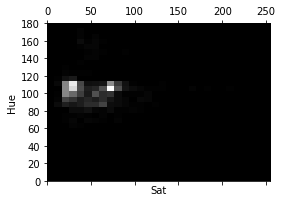

0.6215065805599571


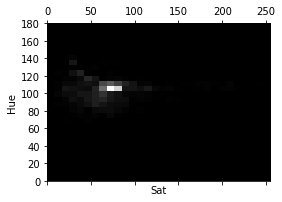

initialisation succed
Mixed_Score for person_0 : 0.8449925904014117
Mixed_Score for person_1 : 0.9116714972863669
Mixed_Score for person_0 : 0.8374451711799371
Mixed_Score for person_1 : 0.7242568851216771
Mixed_Score for person_0 : 0.8600211601139202
Mixed_Score for person_1 : 0.8042408034350457
Mixed_Score for person_0 : 0.8607995984820187
Mixed_Score for person_1 : 0.8007539093727367
Mixed_Score for person_0 : 0.8481694926360691
Mixed_Score for person_1 : 0.8641526497734233
Mixed_Score for person_0 : 0.8333626577237598
Mixed_Score for person_1 : 0.8438747169234544
Mixed_Score for person_0 : 0.8374589977472695
Mixed_Score for person_1 : 0.9560233120277204
Mixed_Score for person_0 : 0.8308289841773024
Mixed_Score for person_1 : 0.940702929752038
Mixed_Score for person_0 : 0.8353135759579657
Mixed_Score for person_1 : 0.9189669808217982
Mixed_Score for person_0 : 0.831901151308189
Mixed_Score for person_1 : 0.9774562769095885
Mixed_Score for person_0 : 0.8378186137021527
Mixed_Score fo

Mixed_Score for person_0 : 0.8152465594744157
Mixed_Score for person_1 : 0.7960670332575116
Mixed_Score for person_0 : 0.8056391313991305
Mixed_Score for person_1 : 0.7218711888183132
Mixed_Score for person_0 : 0.787633961492274
Mixed_Score for person_1 : 0.21933406491817697
Mixed_Score for person_0 : 0.7945969819851685
Mixed_Score for person_1 : 0.039182501709664225
Mixed_Score for person_0 : 0.8038310495409421
Mixed_Score for person_1 : -0.02732042907208218
Mixed_Score for person_0 : 0.8089699399938434
Mixed_Score for person_1 : -0.1589400474710407
Mixed_Score for person_0 : 0.7541776845450359
Mixed_Score for person_1 : -0.11012798100168027
Mixed_Score for person_0 : 0.7909165511578256
Mixed_Score for person_1 : -0.1421176732789176
Mixed_Score for person_0 : 0.8359963856300834
Mixed_Score for person_1 : 0.08655826827037516
Mixed_Score for person_0 : 0.8323066364594912
Mixed_Score for person_1 : -0.26594193078343703
Mixed_Score for person_0 : 0.818182605690932
Mixed_Score for person_1

Mixed_Score for person_0 : 0.49618693848150286
Mixed_Score for person_1 : 0.30741441521723833
Mixed_Score for person_0 : 0.535876688359097
Mixed_Score for person_1 : 0.5918509129229582
Mixed_Score for person_0 : 0.48122243235385265
Mixed_Score for person_1 : 0.50916317739592
Mixed_Score for person_0 : 0.3443862979268305
Mixed_Score for person_1 : 0.8462521234932235
Mixed_Score for person_0 : 0.2147297504053215
Mixed_Score for person_1 : 0.8069679011420774
Mixed_Score for person_0 : 0.33727245832530106
Mixed_Score for person_1 : 0.8348722502258874
Mixed_Score for person_0 : 0.47069583706864554
Mixed_Score for person_1 : -0.07314282692221256
Mixed_Score for person_0 : 0.4993899267068105
Mixed_Score for person_1 : -0.15749287167627496
Mixed_Score for person_0 : 0.3994397014027133
Mixed_Score for person_1 : 0.16469708651494439
Mixed_Score for person_0 : 0.32631399927221516
Mixed_Score for person_1 : 0.12569132163045915
Mixed_Score for person_0 : 0.5437022894773759
Mixed_Score for person_1 

Mixed_Score for person_0 : -0.009606363696469347
Mixed_Score for person_1 : 0.5047920367381309
Mixed_Score for person_0 : 0.3262343994124868
Mixed_Score for person_1 : 0.7952144950412224
Mixed_Score for person_0 : 0.2117701756310187
Mixed_Score for person_1 : 0.7592838725830309
Mixed_Score for person_0 : 0.3477313653628656
Mixed_Score for person_1 : 0.6018527668815432
Mixed_Score for person_0 : 0.08626685158943867
Mixed_Score for person_1 : 0.6849105388859703
Mixed_Score for person_0 : 0.09466340989013303
Mixed_Score for person_1 : 0.7082266771222662
Mixed_Score for person_0 : 0.12349214820022085
Mixed_Score for person_1 : 0.7602766396839387
Mixed_Score for person_0 : 0.11769882878958207
Mixed_Score for person_1 : 0.8093211430939725
Mixed_Score for person_0 : 0.5310881612277796
Mixed_Score for person_1 : 0.6695633529110975
Mixed_Score for person_0 : -0.03825921574036454
Mixed_Score for person_1 : 0.34228910256037237
Mixed_Score for person_0 : 0.1342337615326173
Mixed_Score for person_1

Mixed_Score for person_0 : 0.6604689409210523
Mixed_Score for person_1 : -0.1326265001004097
Mixed_Score for person_0 : 0.44579547324418023
Mixed_Score for person_1 : -0.012096389982598973
Mixed_Score for person_0 : 0.5948618440691371
Mixed_Score for person_1 : 0.11395423355695584
Mixed_Score for person_0 : 0.5999091131810503
Mixed_Score for person_1 : 0.04988043104404993
Mixed_Score for person_0 : 0.28537086325113115
Mixed_Score for person_1 : 0.5072918720763452
Mixed_Score for person_0 : 0.5897207589490077
Mixed_Score for person_1 : 0.718023620545545
Mixed_Score for person_0 : 0.45700893818462296
Mixed_Score for person_1 : 0.5412839210237833
Mixed_Score for person_0 : 0.553314566845867
Mixed_Score for person_1 : 0.055994188815798
Mixed_Score for person_0 : 0.5707182709844216
Mixed_Score for person_1 : -0.21188425836755453
Mixed_Score for person_0 : 0.6679471629764719
Mixed_Score for person_1 : -0.020059627005837785
Mixed_Score for person_0 : 0.1978550732301733
Mixed_Score for person_

Mixed_Score for person_0 : 0.4237159484169605
Mixed_Score for person_1 : 0.07047493060297426
Mixed_Score for person_0 : 0.49028823430258356
Mixed_Score for person_1 : 0.2880752799366456
Mixed_Score for person_0 : 0.600948690509837
Mixed_Score for person_1 : 0.1836960233043373
Mixed_Score for person_0 : 0.5150572505466509
Mixed_Score for person_1 : 0.5961445430433783
Mixed_Score for person_0 : 0.5538133037313638
Mixed_Score for person_1 : 0.3113933971272582
Mixed_Score for person_0 : 0.5770980256746704
Mixed_Score for person_1 : 0.1378106956336997
Mixed_Score for person_0 : 0.5917486861168518
Mixed_Score for person_1 : 0.1621428402412492
Mixed_Score for person_0 : 0.5428210587812223
Mixed_Score for person_1 : 0.6770222514113857
Mixed_Score for person_0 : 0.550783084044704
Mixed_Score for person_1 : 0.8438364469377831
Mixed_Score for person_0 : 0.6567584226506148
Mixed_Score for person_1 : 0.346085304004249
Mixed_Score for person_0 : 0.5613414662574291
Mixed_Score for person_1 : 0.272512

In [26]:
##### Test of the method ######
###############################

#### path of the video
path = VIDEO_PATH+r'\Duo_2.wmv'
videoWriter = cv2.VideoWriter(os.path.join(output_video_path,"test_cross_300_S_1.mp4"),cv2.VideoWriter_fourcc('I','4','2','0'),10,(1280,720))#(512,288))
#cv2.namedWindow('Track')

tracker = Tracker_Final(path)

##### Initialisation of the tracker
tracker.load_model()
tracker.initialise()

#### Tracking phase
frame_count = 0
while True:
    img = tracker.update()
    img = tracker.draw()
    videoWriter.write(img)
    cv2.imshow('Track', img)
    #frame_count += 1
    if(cv2.waitKey(1) == ord('q')):# or frame_count == 300):
        videoWriter.release()
        cv2.destroyAllWindows()
        break


In [59]:
from util import draw_skeleton

In [37]:
# Load histograms for time evaluation

def correl_and_predict(tracker, hist_1, hist_2):
    prediction = tracker.model.predict([hist_1.reshape(1,30,30,1), hist_2.reshape(1,30,30,1)])
    distance = dist = cv2.compareHist(hist_1, hist_2, cv2.HISTCMP_CORREL)

hist_1 = cv2.imread(os.path.join(output_histogram_path, "hist_Person_0_1.png"), 0).astype(np.float32) / 255
hist_2 = cv2.imread(os.path.join(output_histogram_path, "hist_Person_0_18.png"), 0).astype(np.float32) / 255

%timeit correl_and_predict(tracker, hist_1, hist_2)

3.64 ms ± 298 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
### Plot test datas for method evaluations

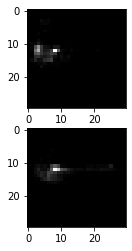

In [75]:
hist_1 = cv2.imread(os.path.join(output_histogram_path,"hist_Person_0_1.png"), 0)
hist_2 = cv2.imread(os.path.join(output_histogram_path,"hist_Person_1_16.png"), 0)

hist_1 = hist_1.astype(np.float32) / 255
hist_2 = hist_2.astype(np.float32) / 255

plt.subplot(211)
plt.imshow(hist_1 , cmap = plt.cm.gray)
plt.subplot(212)
plt.imshow(hist_2 , cmap = plt.cm.gray)

In [77]:

loadded_model.predict([hist_1.reshape(1,30,30,1), hist_2.reshape(1,30,30,1)])


array([[0.75836897]], dtype=float32)

In [80]:
cv2.compareHist(hist_1, hist_2, cv2.HISTCMP_CORREL) 

0.7100689877365118